In [1]:
using JuMP
using Ipopt
using Plots

In [40]:
PT = 0:20 #Points on route
XY = [:x,:y] #Planar dimensions

λ = 1 #weight on speed

H = Symbol.("h",1:2) #Hazards

hloc = Dict( (:h1,:x) => .3,
             (:h1,:y) => .6,
             (:h2,:x) => .7,
             (:h2,:y) => .4
) #Hazard locations

var = (h1 = .12, h2 = .08)

IG = 1:10
JG = IG

xg = IG./10

dist = Dict()

for h∈H,ig∈IG,jg∈JG
    dist[h,ig,jg] = sqrt( (xg[ig]-hloc[h,:x])^2/2 + (xg[jg]-hloc[h,:y])^2/2)
end

hz = Dict()

for ig∈IG,jg∈JG
    hz[ig,jg] = 1 - prod(1-exp(-.5*(dist[h,ig,jg]/var[h])^2) for h∈H)
end

In [41]:
    function route(λ)
    routechoice = Model(Ipopt.Optimizer)

    @variables(routechoice,begin
        0<=X[pt=PT]<=1, (start = 1/(pt+1),)
        0<=Y[pt=PT]<=1, (start = 1/(pt+1),)
        .001<=D<=1, (start = 1/20,)
        P[PT,H]>=0, (start = .1,)
        R[PT,H]>=0
        Z>=0
        0<=L<=2.2
    end)

    @objective(routechoice,Min, λ*L + (1-λ)*Z)

    @NLconstraints(routechoice,begin
        Length, L == sum( sqrt( (X[pt+1] - X[pt])^2 + (Y[pt+1]-Y[pt])^2 )  for pt∈PT[begin:end-1]) #- 1
        hazard, Z == 1 - prod( 1-R[pt,h] for h∈H,pt∈PT)
        distance[pt=PT[begin:end-1]], D^2 == (X[pt+1]-X[pt])^2 + (Y[pt+1] - Y[pt])^2
        proximity[pt=PT[begin:end-1], h=H], P[pt+1,h] == sqrt(((X[pt+1]+X[pt])/2-hloc[h,:x])^2 +
                                                            ((Y[pt+1]+Y[pt])/2-hloc[h,:y])^2)
        risk[pt=PT[begin:end-1],h=H], R[pt+1,h] == exp(-.5 * (P[pt+1,h]/var[h])^2)*D
    end)

    fix.(R[0,H],0,force=true) #no risk on the arc leading to point 0

    #	Start in the southeast (1,0) and traverse to the northwest (0,1):
    fix(X[0],1, force=true)
    fix(X[20],0,force=true)

    fix(Y[0],0, force=true)
    fix(Y[20],1,force=true)

    return routechoice

end


route (generic function with 1 method)

In [42]:
sols = Dict()

for θ∈[0,30,60,90]
    println(θ)
    λ = cos(pi*θ/180)/(cos(pi*θ/180) + sin(pi*θ/180))
    routechoice = route(λ)
    set_silent(routechoice)
    optimize!(routechoice)

    sols[θ] = routechoice
end

0


30


60


90

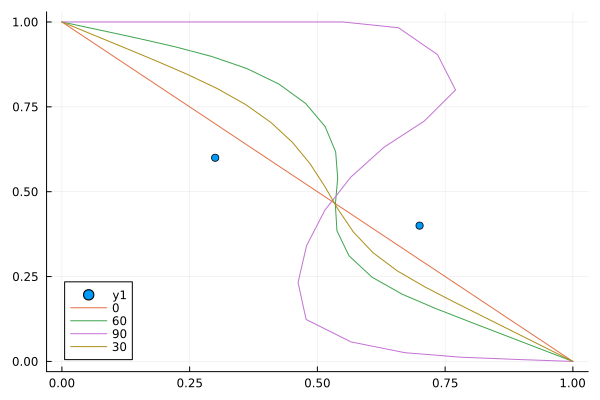

In [43]:

plt = plot([hloc[h,:x] for h∈H],[hloc[h,:y] for h∈H],seriestype=:scatter)

for (angle,m) in sols
    x = value.(m[:X]).data
    y = value.(m[:Y]).data
    plot!(plt,x,y,label=angle)
end
plt

In [27]:
x

21-element Vector{Float64}:
 1.0
 0.9421361907276411
 0.8842724493916582
 0.8264119177637137
 0.7686160910650665
 0.7114147741951605
 0.6568618909339795
 0.6087514083696101
 0.5702511169082636
 0.5406253962947841
 ⋮
 0.45122410329774326
 0.4089267095568254
 0.359373906711408
 0.30411280165211496
 0.24521681977292104
 0.1845142493328164
 0.12314068067682815
 0.06158738306193041
 0.0